# Example 9 - Constructing the Voronoi diagram

The dual of a Delaunay triangulation is its Voronoi diagram. Stripy can efficiently calculate the voronoi points from a triangulation and, optionally, build the Voronoi regions for you.

## Notebook contents

- [Voronoi points](#Voronoi-points)
- [Voronoi regions](#Voronoi-regions)

In [1]:
import numpy as np
import stripy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
## Set up a coarse mesh for visual clarity

mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3)

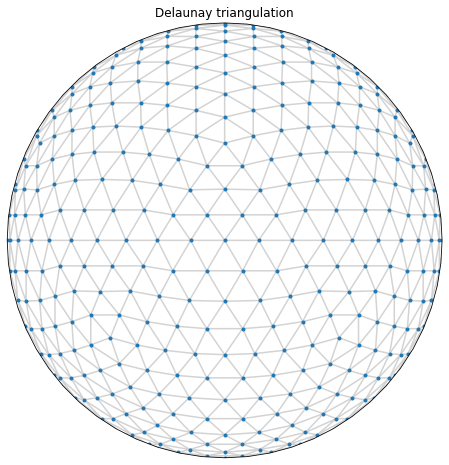

In [3]:
proj_map = ccrs.Orthographic()
proj_flat = ccrs.PlateCarree()


lons = np.degrees(mesh.lons)
lats = np.degrees(mesh.lats)


fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111, projection=proj_map, title="Delaunay triangulation")

ax.triplot(lons, lats, mesh.simplices, c='LightGrey', zorder=1, transform=proj_flat)
ax.scatter(lons, lats, c='C0', marker='.', zorder=2, transform=proj_flat)

plt.show()

## Voronoi points

A voronoi point (or circumcentre) exists for every triangle in the mesh. They are calculated by finding a constant radius (the circumradius) that is shared between each point in the triangle. Depending on the mesh, some voronoi points will reside outside the area contained within a triangle.

To calculate the Voronoi points from the mesh, use the `voronoi_points` method. This method may optionally return the circumradius, signed triangle area, or aspect ratio for each voronoi point.

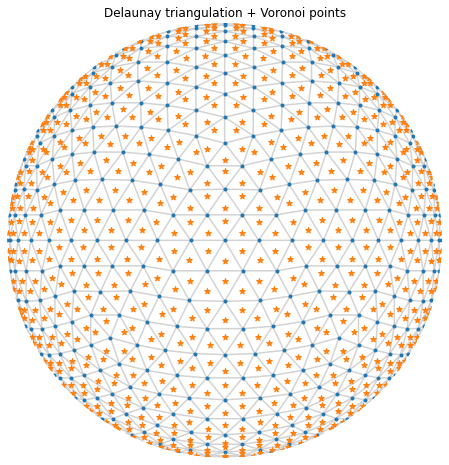

In [4]:
vor_lons, vor_lats = mesh.voronoi_points()
vlons = np.degrees(vor_lons)
vlats = np.degrees(vor_lats)


fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111, projection=proj_map, title="Delaunay triangulation + Voronoi points")

ax.axis('off')
ax.triplot(lons, lats, mesh.simplices, c='LightGrey', zorder=1, transform=proj_flat)
ax.scatter(lons, lats, c='C0', marker='.', zorder=2, transform=proj_flat)
ax.scatter(vlons, vlats, c='C1', marker='*', zorder=3, transform=proj_flat)

plt.show()

## Voronoi regions

Often it is desirable to obtain the corresponding region enclosed by voronoi points. We can easily find the line segments connecting each voronoi point by retrieving the neighbour simplices.

In [5]:
neighbours = mesh.neighbour_simplices()

circumcentres = np.column_stack([vlons, vlats])
voronoi_edges = circumcentres[neighbours]
voronoi_edges[neighbours == -1] = np.nan # remove edges at infinity


lines = []
lines.extend(zip(circumcentres, voronoi_edges[:,0,:]))
lines.extend(zip(circumcentres, voronoi_edges[:,1,:]))
lines.extend(zip(circumcentres, voronoi_edges[:,2,:]))

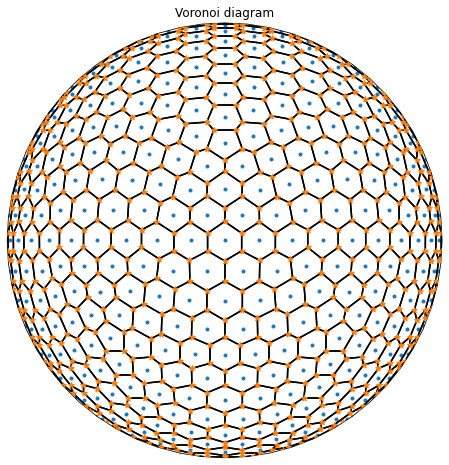

In [6]:
# Plot it
from matplotlib.collections import LineCollection

linesC = LineCollection(lines, edgecolor='k', transform=proj_flat)

fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111, projection=proj_map, title='Voronoi diagram')

ax.scatter(lons, lats, c='C0', marker='.', zorder=2, transform=proj_flat)
ax.scatter(vlons, vlats, c='C1', marker='*', zorder=3, transform=proj_flat)
ax.add_collection(linesC)

plt.show()

Looks good! But in order to find which voronoi points belong to a region, we need to iterate through all of the triangles. Since each vertex in the Delaunay represents a voronoi "site", we can accumulate all of the circumcentres into a list and sort them using `voronoi_points_and_regions`.

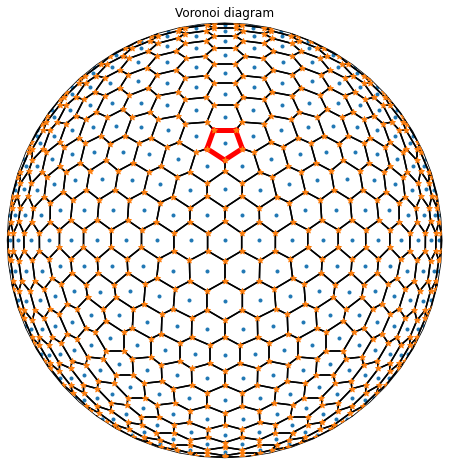

In [7]:
vor_lons, vor_lats, regions = mesh.voronoi_points_and_regions()

linesC = LineCollection(lines, edgecolor='k', transform=proj_flat)

fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111, projection=proj_map, title='Voronoi diagram')

ax.scatter(lons, lats, c='C0', marker='.', zorder=2, transform=proj_flat)
ax.scatter(vlons, vlats, c='C1', marker='*', zorder=3, transform=proj_flat)
ax.add_collection(linesC)

# highlight specific region
r = 1
region = regions[r]

# iterate through region and connect up the points
for i in range(len(region)):
    i0 = region[i - 1]
    i1 = region[i]

    ilon = [vlons[i0], vlons[i1]]
    ilat = [vlats[i0], vlats[i1]]
    ax.plot(ilon, ilat, c='r', linewidth=5, transform=proj_flat)